1\. **Hurricanes per Year**

The number of hurricanes in 2005 was 15. The historic average is 6.3. Is this number signficantly different?
- Assume the number of hurricanes is random, i.e. follows the Poisson distribution.
- Assume as statistically significant a probability that has a Z score of 3 or larger with respect a normal distribution.

**Hint**: compute the probability that in a single year are observed 15 or more hurricances.

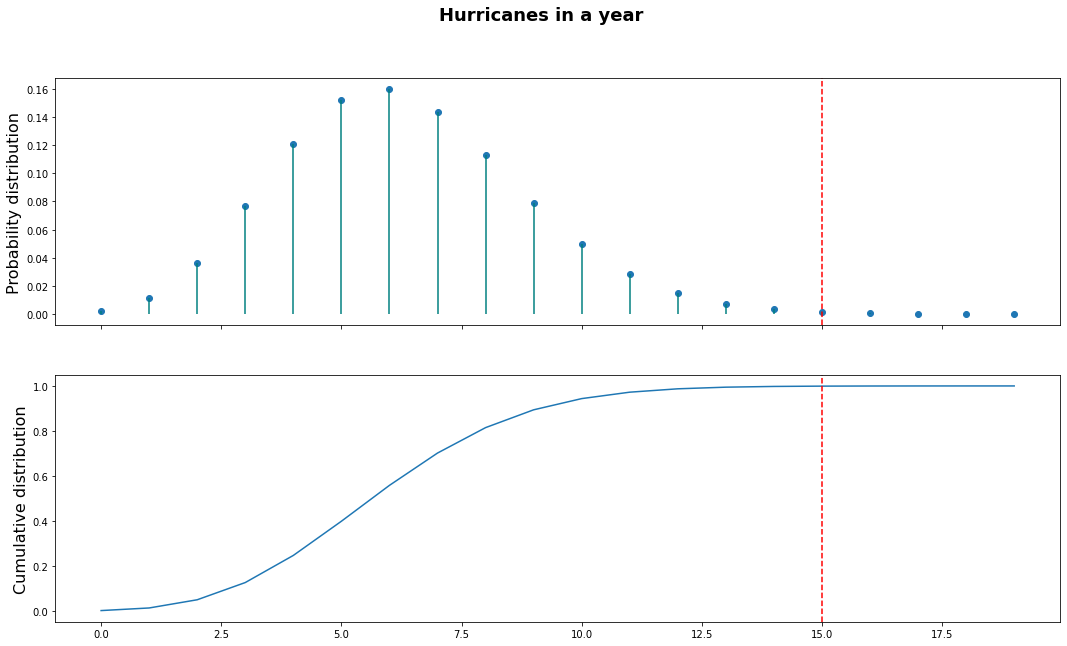

The Z value is 3.4661629670697414
alpha =  0.0013498980316301035
pvalue = 0.00026397158691493505
Reject the null hypothesis that the difference isn't statistically significant


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

hurr_2005 = 15
hurr_avg = 6.3
x = np.arange(0, 20, 1)
poiss = stats.poisson.pmf(x, 6.3, loc = 0)
cum = stats.poisson.cdf(x, 6.3, loc = 0)
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize = (18,10))
fig.suptitle('Hurricanes in a year', fontsize = 18, fontweight = 'heavy')
ax1.scatter(x, poiss)
ax1.vlines(x, 0, poiss, color='teal')
ax1.set_ylabel('Probability distribution', fontsize = 16)
ax1.axvline(15, linestyle='--', color='red')
ax2.plot(x, cum)
ax2.set_ylabel('Cumulative distribution', fontsize = 16)
ax2.axvline(15, linestyle='--', color='red')
plt.show()
y = 1 - stats.poisson.cdf(15, 6.3, 0) #Probability of observing more than 15 hurricanes in a year

Z = ((hurr_2005-hurr_avg)/np.sqrt(hurr_avg))
print('The Z value is', Z)
#print('The probability of observing more than', hurr_2005, 'hurricanes in a year is', y)

#statistically significant condition
alpha = (1. - stats.norm.cdf(3))
print('alpha = ', alpha)

#one tail p value
pvalue = 1-stats.norm.cdf(Z)

print('pvalue =', pvalue)

if(pvalue < alpha): 
    print('Reject the null hypothesis that the difference isn\'t statistically significant')
else:
    print('Accept the null hypothesis')

2\. **Pairwise t-test**

In an experiment, a group of 10 individuals agreed to participate in a study of blood pressure changes following exposure to halogen lighting. Resting systolic blood pressure was recorded for each individual. The participants were then exposed to 20 minutes in a room lit only by halogen lamps. A post-exposure systolic blood pressure reading was recorded for each individual. The results are presented in the following data set:

```python
pre = np.array([120, 132, 120, 110, 115, 128, 120, 112, 110, 100])
post = np.array([140, 156, 145, 130, 117, 148, 137, 119, 127, 135])
```

Determine whether the change in blood pressures within our sample was statistically significant.

**Hint:**
in this case, the Student's $t$-test should be performed to compare the two datasets.
Use the following test statistics:

$$T = \frac{\bar{x}_1 - \bar{x}_2}{\sigma \sqrt{\frac{2}{n}}}$$

and 

$$\sigma = \sqrt{\frac{\sigma_1^2 + \sigma_2^2}{2}}$$

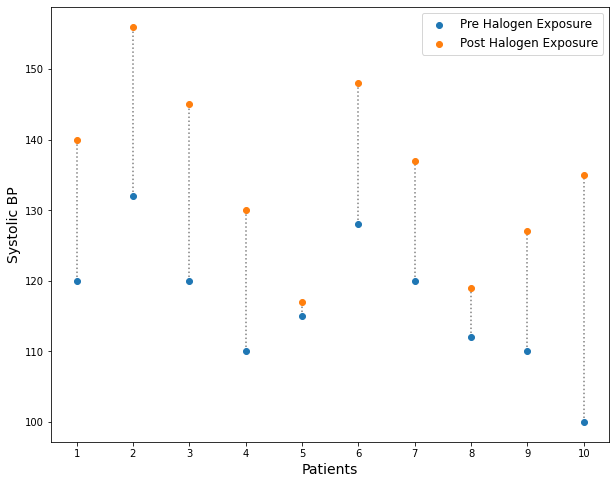

T test result: -3.786997938137629
pvalue =  0.002151232066432296
Depending on the confidence level (alpha) we pick we then reject or accept the null hypothesis that datasets are sampled from the same distribution.
For alpha = 0.05 (typically used in medicine), we have: 
Reject the null hypothesis that the datasets are sampled from the same distribution.


In [14]:
pre = np.array([120, 132, 120, 110, 115, 128, 120, 112, 110, 100])
post = np.array([140, 156, 145, 130, 117, 148, 137, 119, 127, 135])
x = np.array([i for i in range(1,11)])

fig = plt.figure(figsize = (10,8))
ax = fig.subplots()
ax.set_xticks(x)
ax.set_xlabel('Patients', fontsize = 14)
ax.set_ylabel('Systolic BP', fontsize = 14)
ax.scatter(x, pre, label = 'Pre Halogen Exposure')
ax.scatter(x, post, label = 'Post Halogen Exposure')
ax.plot((x,x),([i for i in pre], [j for j in post]), c = 'grey', linestyle = 'dotted', zorder = 0)
ax.legend(loc = 'best', fontsize = 12)
plt.show()

var1 = np.var(pre, ddof=1)
var2 = np.var(post, ddof=1)

#create new sigma variable
sigma_pair = np.sqrt(0.5*(var1+var2))

#test statistic
T = (np.mean(pre)- np.mean(post)) / (sigma_pair * np.sqrt(2/len(pre)))

print('T test result:', T)
pvaluehalo = stats.t.cdf(T, len(post)-1)
print('pvalue = ', pvaluehalo)

print('Depending on the confidence level (alpha) we pick we then reject or accept the null hypothesis that datasets are sampled from the same distribution.')
alphahalo = 0.05
print('For alpha =', alphahalo, '(typically used in medicine), we have: ')

if(pvaluehalo < alphahalo): 
    print('Reject the null hypothesis that the datasets are sampled from the same distribution.')
else:
    print('Accept the null hypothesis that the datasets are sampled from the same distribution.')


3\. **FFT of a simple dataset**

Perform a periodicity analysis on the lynxs-hares population, i.e. determine what is the period of the population of these animals.

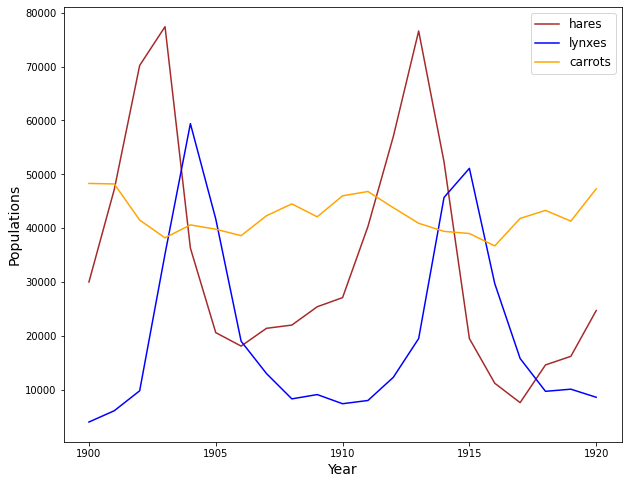

In [70]:
from scipy import fftpack

data = np.loadtxt('populations.txt')

year, hares, lynxes, carrots = data.T

fig = plt.figure(figsize = (10,8))
ax = fig.subplots()
ax.plot(year, hares, color = 'brown', label = 'hares')
ax.plot(year, lynxes, color = 'blue', label = 'lynxes')
ax.plot(year, carrots, color = 'orange', label = 'carrots')
ax.set_xlabel('Year', fontsize = 14)
ax.set_ylabel('Populations', fontsize = 14)
ax.set_xticks(year[::5])
ax.legend(loc = 'best', fontsize = 12)
plt.show()

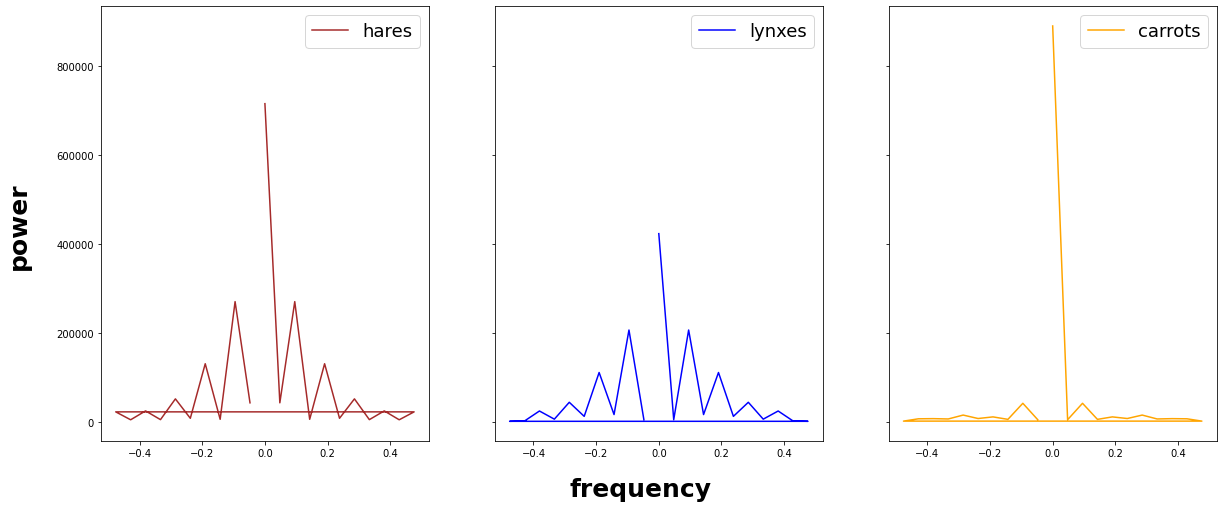

Peak frequency for hares is  0.09523809523809523  years^{-1}. The period is the reciprocal, so:  10.5 years.
Peak frequency for lynxes is  0.09523809523809523  years^{-1}. The period is the reciprocal, so:  10.5 years.
Peak frequency for carrots is  0.09523809523809523  years^{-1}. The period is the reciprocal, so:  10.5 years.


In [4]:
timestep = 1

# fft analysis hares

hares_fft = fftpack.fft(hares)
hares_sample_freq = fftpack.fftfreq(hares.size, d = timestep)
hares_power = np.abs(hares_fft)
hares_pos_mask = np.where(hares_sample_freq > 0)
hares_freqs = hares_sample_freq[hares_pos_mask]
hares_peak_freq = hares_freqs[hares_power[hares_pos_mask].argmax()]


#repeat for lynxes and carrots
lynxes_fft = fftpack.fft(lynxes)
lynxes_power = np.abs(lynxes_fft)
lynxes_sample_freq = fftpack.fftfreq(lynxes.size, d = timestep)
lynxes_pos_mask = np.where(lynxes_sample_freq > 0)
lynxes_freqs = lynxes_sample_freq[lynxes_pos_mask]
lynxes_peak_freq = lynxes_freqs[lynxes_power[lynxes_pos_mask].argmax()]
carrots_fft = fftpack.fft(carrots)
carrots_power = np.abs(carrots_fft) 
carrots_sample_freq = fftpack.fftfreq(carrots.size, d = timestep)
carrots_pos_mask = np.where(carrots_sample_freq > 0)
carrots_freqs = carrots_sample_freq[carrots_pos_mask]
carrots_peak_freq = carrots_freqs[carrots_power[carrots_pos_mask].argmax()]

#Plot
fig, (ax_hares, ax_lynxes, ax_carrots) = plt.subplots(1, 3, sharey = True, figsize=(20,8))

ax_hares.plot(hares_sample_freq, hares_power, color = 'brown', label = 'hares')
ax_lynxes.plot(lynxes_sample_freq, lynxes_power, color = 'blue', label = 'lynxes')
ax_carrots.plot(carrots_sample_freq, carrots_power, 'orange', label = 'carrots')
ax_hares.legend(loc = 'best', fontsize = 18)
ax_lynxes.legend(loc = 'best', fontsize = 18)
ax_carrots.legend(loc = 'best', fontsize = 18)

fig.text(0.5, 0.03, 'frequency', ha='center', fontsize = 25, fontweight = 'heavy')
fig.text(0.06, 0.5, 'power', va='center', rotation='vertical', fontsize = 25, fontweight = 'heavy')

#fig1 = plt.figure(figsize = (16, 8))
#ax_together = plt.subplot()
#ax_together.plot(hares_sample_freq, hares_power, color = 'brown')
#ax_together.plot(lynxes_sample_freq, lynxes_power, color = 'blue')
#ax_together.plot(carrots_sample_freq, carrots_power, 'orange')

plt.show()

names = ['hares', 'lynxes', 'carrots']
peak_freq = [hares_peak_freq, lynxes_peak_freq, carrots_peak_freq]
for i, j in enumerate(names):
    print('Peak frequency for', j, 'is ', peak_freq[i],' years^{-1}. The period is the reciprocal, so: ', 1/peak_freq[i], 'years.')


4\. **FFT of an image**

Write a filter that removes the periodic noise from the `moonlanding.png` image by using a 2-dimensional FFT.

* Import the image as a 2D numpy array using `plt.imread("moonlanding.png")`. Examine the image with `plt.imshow()`, which is heavily contaminated with periodic noise.
* Check the documentation of the `scipy.fftpack` package, and find the method that performs a 2D FFT. Plot the spectrum (Fourier transform of) the image. **Hint**: use `LogNorm` to plot the colors in log scale:
```Python
from matplotlib.colors import LogNorm
plt.imshow(image, norm=LogNorm(vmin=5))
```
* Inspect the spectrum, and try to locate the regions of the power spectrum that contain the signal and those which contain the periodic noise. Use array slicing to set the noise regions to zero.
* Apply the inverse Fourier transform to plot the resulting image.

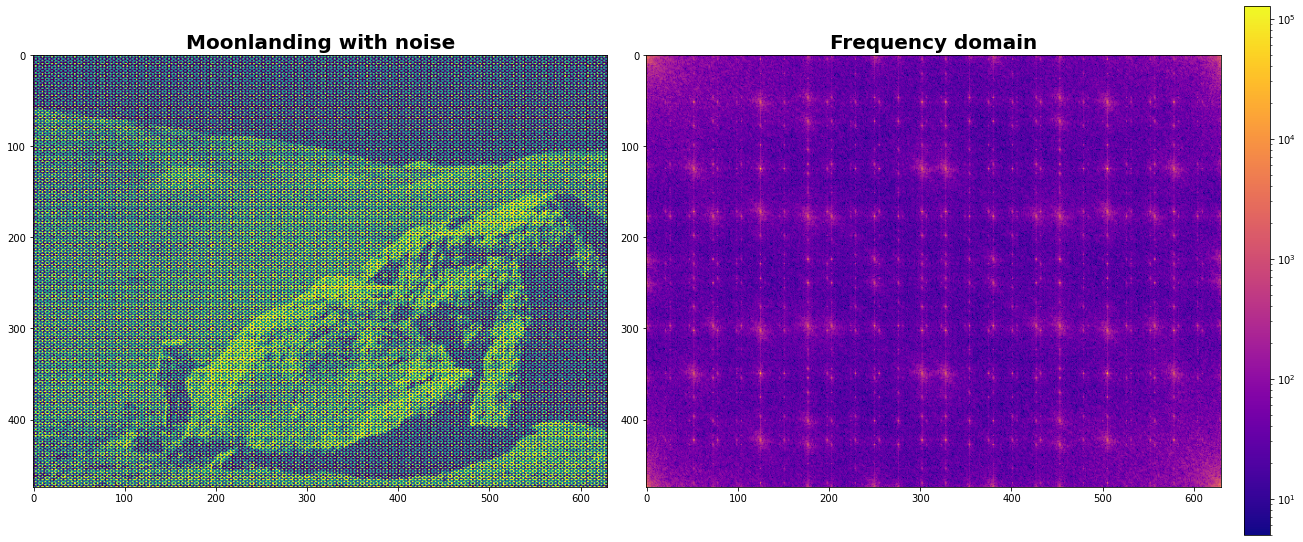

In [18]:
#Import image, and examine it
from matplotlib import colors
from scipy.signal import argrelextrema


moon = plt.imread('moonlanding.png')
fig =  plt.figure(figsize = (18, 10), constrained_layout=True)
ax = fig.add_subplot(121)
original_image = ax.imshow(moon)
ax.set_title('Moonlanding with noise', fontsize = 20, fontweight = 'heavy')

#Plot the spectrum
ax1 = fig.add_subplot(122)
moon_fft = fftpack.fft2(moon)
spectrum = ax1.imshow(np.abs(moon_fft), norm = colors.LogNorm(vmin = 5), cmap = 'plasma')
fig.colorbar(spectrum, orientation = 'vertical', ax = ax1, fraction=0.046, pad=0.04)
ax1.set_title('Frequency domain', fontsize = 20, fontweight = 'heavy')

plt.show()

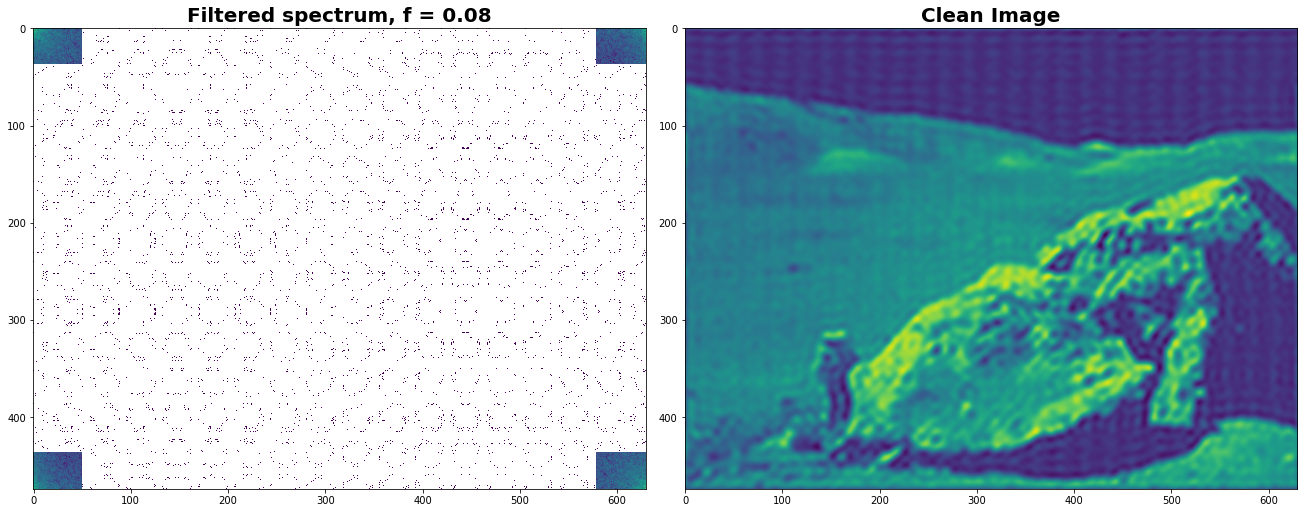

In [81]:
#Inspect the spectrum, and try to locate the regions of the power spectrum...

threshold = 0.08
rows, cols = moon_fft.shape
fig =  plt.figure(figsize = (18, 10), constrained_layout=True)
ax_filt = fig.add_subplot(121)
ax_clean = fig.add_subplot(122)

copy_moon = moon_fft.copy()
copy_moon[int(rows*threshold):int(rows*(1-threshold))] = 0
copy_moon[:, int(cols*threshold):int(cols*(1-threshold))] = 0

ax_filt.imshow(np.abs(copy_moon), norm = colors.LogNorm(vmin = 5))
ax_filt.set_title('Filtered spectrum, f = 0.08',fontsize = 20, fontweight = 'heavy' )
ax_clean.imshow(fftpack.ifft2(copy_moon).real)
ax_clean.set_title('Clean Image', fontsize = 20, fontweight = 'heavy')
plt.show()